Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [4]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data

col_names = ['bathrooms', 'bedrooms', 'created', 'description', 'address', 'latitude', 'longitude', 'price', 'street', 'interest', 'elevator', 'cats', 'hardwood', 'dogs', 'doorman', 'dishwasher', 'no_fee', 'laundry_building', 'gym', 'pre-war', 'laundry_unit', 'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 'pool', 'new', 'terrace', 'exclusive', 'loft', 'patio', 'wheelchair', 'common_outdoor']

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 header=0,
                 names=col_names)

assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]


### **Let's adjust the listing times to just date, no time**

In [5]:
df['created']=pd.to_datetime(df['created'])

In [6]:
df['created']=df['created'].dt.date

### **Let's engineer some more inclusive features**

In [7]:
df['total_rooms']=df['bathrooms']+df['bedrooms']

In [8]:
df['outdoor_perks']=df['roof_deck']+df['outdoor_space']+df['balcony']+df['terrace']+df['patio']+df['common_outdoor']

In [9]:
df['pet_friendliness_score']=df['cats']+df['dogs']

### **Let's check our work so far**

In [10]:
df.head()

,bathrooms,bedrooms,created,description,address,latitude,longitude,price,street,interest,elevator,cats,hardwood,dogs,doorman,dishwasher,no_fee,laundry_building,gym,pre-war,laundry_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,pool,new,terrace,exclusive,loft,patio,wheelchair,common_outdoor,total_rooms,outdoor_perks,pet_friendliness_score
0,1.5,3,2016-06-24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,0,0
1,1.0,2,2016-06-12,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,2
2,1.0,1,2016-04-17,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0
3,1.0,1,2016-04-18,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0
4,1.0,4,2016-04-28,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0,0


### **Let's see how certain factors correlate to price**

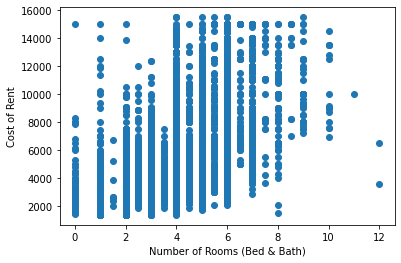

In [11]:
import matplotlib.pyplot as plt
plt.scatter(df['total_rooms'], df['price'])
plt.xlabel('Number of Rooms (Bed & Bath)')
plt.ylabel('Cost of Rent');

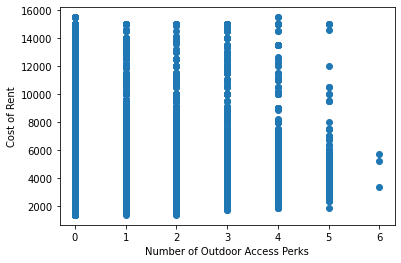

In [12]:
plt.scatter(df['outdoor_perks'], df['price'])
plt.xlabel('Number of Outdoor Access Perks')
plt.ylabel('Cost of Rent');

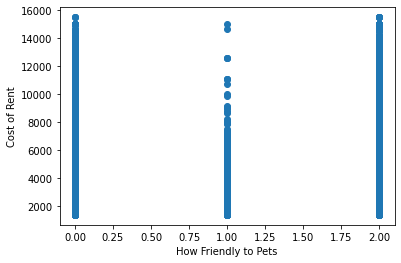

In [13]:
plt.scatter(df['pet_friendliness_score'], df['price'])
plt.xlabel('How Friendly to Pets')
plt.ylabel('Cost of Rent');

### **Let's reindex our dataframe for easier slicing**

In [78]:
df.set_index('created', inplace=True)

KeyError: ignored

### **Let's check our work so far**

In [79]:
df.head()

,bathrooms,bedrooms,description,address,latitude,longitude,price,street,interest,elevator,cats,hardwood,dogs,doorman,dishwasher,no_fee,laundry_building,gym,pre-war,laundry_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,pool,new,terrace,exclusive,loft,patio,wheelchair,common_outdoor,total_rooms,outdoor_perks,pet_friendliness_score
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,0,0
2016-06-12,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,2
2016-04-17,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0
2016-04-18,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0
2016-04-28,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0,0


### **Let's separate our features from our target**

In [80]:
y = df['price']
X = df[['total_rooms','outdoor_perks','pet_friendliness_score']]

In [71]:
cutoff = datetime.date(2016, 6, 1)

In [82]:
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

### **Let's check our work so far**

In [84]:
X_test

,total_rooms,outdoor_perks,pet_friendliness_score
created,,,
2016-06-24,4.5,0,0
2016-06-12,3.0,0,2
2016-06-03,2.0,0,0
2016-06-01,2.0,0,0
2016-06-07,6.0,3,2
...,...,...,...
2016-06-16,3.0,0,0
2016-06-21,4.0,0,0
2016-06-02,2.0,0,2


### **Let's establish a baseline**

In [85]:
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()]*len(y_train)
print('Mean Cost of Rent:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean Cost of Rent: 3575.604007034292
Baseline MAE: 1201.8811133682555


### **Let's build our model**

In [86]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train);

### **Let's obtain our Mean Absolute Error**

In [87]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 882.1113036637008
Test MAE: 894.9684926012002


### **Let's obtain our Root Mean Squared Error**



In [89]:
from sklearn.metrics import mean_squared_error
print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Test RMSE:', mean_squared_error(y_test, model.predict(X_test), squared=False))

Training RMSE: 1329.3910616382814
Test RMSE: 1325.1918806911247


### **Let's obtain our $R^2$ score**

In [90]:
from sklearn.metrics import r2_score
print('Training R^2:', r2_score(y_train, model.predict(X_train)))
print('Test R^2:', r2_score(y_test, model.predict(X_test)))

Training R^2: 0.43083267824084615
Test R^2: 0.4349673411781211


### **Let's find our model's intercept**

In [91]:
model.intercept_

1252.7930202150292

### **Let's find our model's coefficient**

In [92]:
model.coef_

array([793.31897736, 160.56742829,  89.29480761])